# Xây Dựng & Đánh Giá Models

**Sinh viên:** Phạm Phú Hòa  
**MSSV:** 23122030

**Mục đích:** Train 5 recommendation models (Popularity, ItemCF, UserCF, SVD, ALS) và so sánh hiệu năng qua metrics (Precision, Recall, NDCG, Coverage).

## 1. Thiết Lập

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from models import (
    PopularityRecommender,
    ItemBasedCF,
    TruncatedSVD,
    ALSRecommender
)
from evaluation import (
    precision_at_k,
    recall_at_k,
    f1_at_k,
    ndcg_at_k,
    coverage,
    diversity,
    evaluate_model
)

np.random.seed(42)
sns.set_style('whitegrid')

## 2. Load Dữ Liệu Đã Xử Lý

In [2]:
# Load train/test data
data = np.load('../data/processed/preprocessed_data.npz')
train_users = data['train_users']
train_products = data['train_products']
train_ratings = data['train_ratings']
test_users = data['test_users']
test_products = data['test_products']
test_ratings = data['test_ratings']
n_users = int(data['n_users'])
n_products = int(data['n_products'])

# Load statistics
user_stats = np.load('../data/processed/user_stats.npy')
product_stats = np.load('../data/processed/product_stats.npy')

print(f"Dữ liệu đã load:")
print(f"  Users: {n_users}")
print(f"  Products: {n_products}")
print(f"  Train ratings: {len(train_ratings)}")
print(f"  Test ratings: {len(test_ratings)}")

Dữ liệu đã load:
  Users: 22480
  Products: 12153
  Train ratings: 159342
  Test ratings: 39835


## 3. Xây Dựng User-Item Matrix

In [3]:
# Build dense user-item matrix
train_matrix = np.zeros((n_users, n_products))
for user, product, rating in zip(train_users, train_products, train_ratings):
    train_matrix[user, product] = rating

print(f"User-item matrix shape: {train_matrix.shape}")
print(f"Non-zero entries: {np.count_nonzero(train_matrix):,}")
print(f"Sparsity: {1 - np.count_nonzero(train_matrix)/train_matrix.size:.6f}")
print(f"Memory: {train_matrix.nbytes / 1e6:.1f} MB")

User-item matrix shape: (22480, 12153)
Non-zero entries: 159,342
Sparsity: 0.999417
Memory: 2185.6 MB


## 4. Training Models

Train cả 5 models.

In [4]:
models = {}
t_start = time()

# (1) Popularity
print("Training Popularity...")
t0 = time()
pop_model = PopularityRecommender()
pop_model.fit(train_products, train_ratings)
models['Popularity'] = pop_model
print(f"  Done in {time()-t0:.2f}s")

# (2) ItemCF
print("\nTraining ItemCF...")
t0 = time()
itemcf_model = ItemBasedCF(k=20)
itemcf_model.fit(train_matrix)
models['ItemCF'] = itemcf_model
print(f"  Done in {time()-t0:.2f}s")

# (3) SVD
print("\nTraining SVD...")
t0 = time()
svd_model = TruncatedSVD(n_components=50, n_iterations=5)
svd_model.fit(train_matrix)
models['SVD'] = svd_model
print(f"  Done in {time()-t0:.2f}s")

# (5) ALS
print("\nTraining ALS...")
t0 = time()
als_model = ALSRecommender(n_factors=50, n_iterations=10, lambda_reg=0.01)
als_model.fit(train_users, train_products, train_ratings, n_users, n_products)
models['ALS'] = als_model
print(f"  Done in {time()-t0:.2f}s")

print(f"\n=== Tổng kết ===")
print(f"Models trained: {list(models.keys())}")
print(f"Total training time: {time()-t_start:.1f}s")

Training Popularity...
  Done in 0.03s

Training ItemCF...
  Done in 36.75s

Training SVD...
  Done in 221.09s

Training ALS...
  Done in 154.88s

=== Tổng kết ===
Models trained: ['Popularity', 'ItemCF', 'SVD', 'ALS']
Total training time: 412.8s


In [5]:
K = 10  # Top-K recommendations

# Nhóm test data theo user
test_user_items = {}
for user, product, rating in zip(test_users, test_products, test_ratings):
    if rating >= 4.0:  # Coi 4+ sao là relevant
        if user not in test_user_items:
            test_user_items[user] = []
        test_user_items[user].append(product)

print(f"Đánh giá trên {len(test_user_items)} test users có relevant items (rating >= 4)")

Đánh giá trên 15422 test users có relevant items (rating >= 4)


In [6]:
# Evaluate each model với progress tracking
results = {}
total_models = len(models)

for idx, (model_name, model) in enumerate(models.items(), 1):
    print(f"\n[{idx}/{total_models}] Evaluating {model_name}...")
    t_eval_start = time()
    
    precisions = []
    recalls = []
    f1s = []
    ndcgs = []
    all_recs = []
    
    for user, relevant_items in test_user_items.items():
        # Generate recommendations
        if model_name == 'Popularity':
            recs = model.recommend(n=K)
        elif model_name in ['ItemCF', 'SVD']:
            user_ratings = train_matrix[user, :]
            if np.sum(user_ratings > 0) == 0:
                continue  # Skip cold-start users
            scores = model.predict(user, user_ratings)
            recs = np.argsort(scores)[::-1][:K]
        elif model_name == 'ALS':
            scores = model.predict_for_user(user)
            recs = np.argsort(scores)[::-1][:K]
        else:
            continue
        
        # Filter out already-rated items
        already_rated = np.where(train_matrix[user, :] > 0)[0]
        recs = [item for item in recs if item not in already_rated][:K]
        
        all_recs.append(recs)
        
        # Compute metrics
        precisions.append(precision_at_k(relevant_items, recs, K))
        recalls.append(recall_at_k(relevant_items, recs, K))
        f1s.append(f1_at_k(relevant_items, recs, K))
        ndcgs.append(ndcg_at_k(relevant_items, recs, K))
    
    # Coverage
    cov = coverage(all_recs, n_products)
    
    results[model_name] = {
        'Precision@10': np.mean(precisions),
        'Recall@10': np.mean(recalls),
        'F1@10': np.mean(f1s),
        'NDCG@10': np.mean(ndcgs),
        'Coverage': cov,
        'N_users': len(precisions)
    }
    
    t_eval = time() - t_eval_start
    print(f"  Evaluation time: {t_eval:.2f}s")
    print(f"  Precision@10: {results[model_name]['Precision@10']:.4f}")
    print(f"  Recall@10: {results[model_name]['Recall@10']:.4f}")
    print(f"  F1@10: {results[model_name]['F1@10']:.4f}")
    print(f"  NDCG@10: {results[model_name]['NDCG@10']:.4f}")
    print(f"  Coverage: {results[model_name]['Coverage']:.4f}")
    print(f"  Users evaluated: {results[model_name]['N_users']}")


[1/4] Evaluating Popularity...
  Evaluation time: 2.67s
  Precision@10: 0.0039
  Recall@10: 0.0210
  F1@10: 0.0063
  NDCG@10: 0.0124
  Coverage: 0.0008
  Users evaluated: 15422

[2/4] Evaluating ItemCF...
  Evaluation time: 104.56s
  Precision@10: 0.0107
  Recall@10: 0.0388
  F1@10: 0.0143
  NDCG@10: 0.0282
  Coverage: 0.9672
  Users evaluated: 15418

[3/4] Evaluating SVD...
  Evaluation time: 35.38s
  Precision@10: 0.0184
  Recall@10: 0.0514
  F1@10: 0.0215
  NDCG@10: 0.0375
  Coverage: 0.0377
  Users evaluated: 15418

[4/4] Evaluating ALS...
  Evaluation time: 33.87s
  Precision@10: 0.0246
  Recall@10: 0.0745
  F1@10: 0.0305
  NDCG@10: 0.0543
  Coverage: 0.0724
  Users evaluated: 15422


## 6. So Sánh Models

In [7]:
# Create comparison table
import pandas as pd

df = pd.DataFrame(results).T
df = df[['Precision@10', 'Recall@10', 'F1@10', 'NDCG@10', 'Coverage', 'N_users']]
print("\n=== Model Comparison ===")
print(df.round(4))


=== Model Comparison ===
            Precision@10  Recall@10   F1@10  NDCG@10  Coverage  N_users
Popularity        0.0039     0.0210  0.0063   0.0124    0.0008  15422.0
ItemCF            0.0107     0.0388  0.0143   0.0282    0.9672  15418.0
SVD               0.0184     0.0514  0.0215   0.0375    0.0377  15418.0
ALS               0.0246     0.0745  0.0305   0.0543    0.0724  15422.0


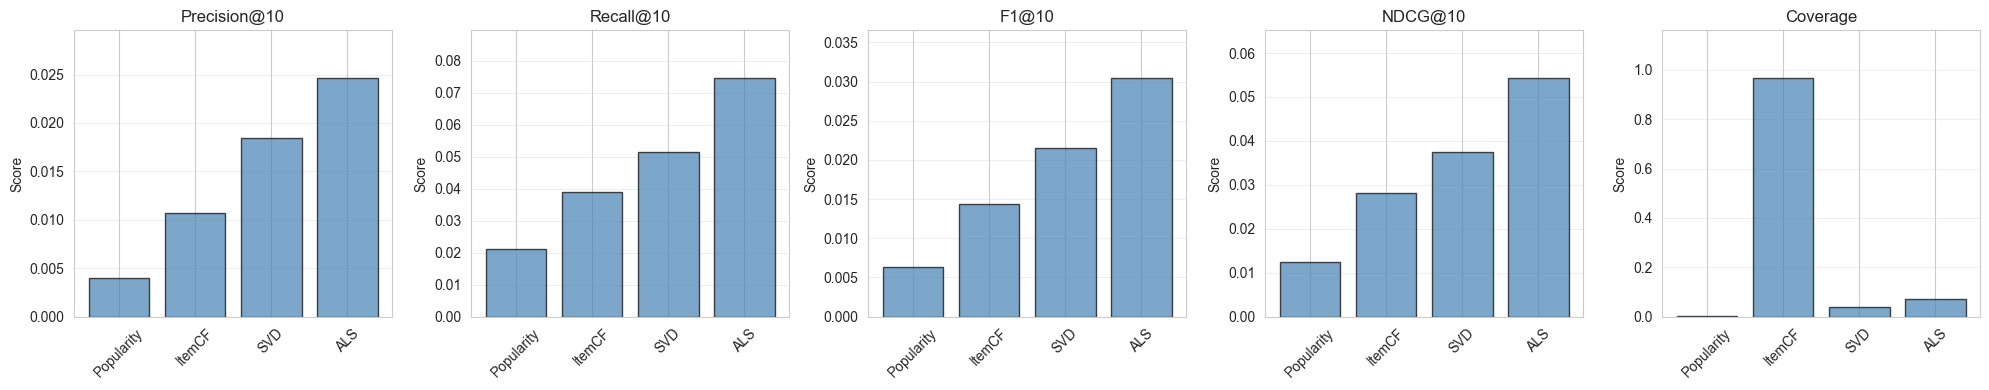

In [8]:
# Visualization
metrics_to_plot = ['Precision@10', 'Recall@10', 'F1@10', 'NDCG@10', 'Coverage']
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(20, 4))

for i, metric in enumerate(metrics_to_plot):
    values = [results[model][metric] for model in models.keys()]
    axes[i].bar(models.keys(), values, color='steelblue', alpha=0.7, edgecolor='black')
    axes[i].set_title(metric)
    axes[i].set_ylabel('Score')
    axes[i].set_ylim([0, max(values)*1.2])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Phân Tích Model Tốt Nhất

Xác định model tốt nhất cho từng metric.

In [9]:
print("\n=== Models Tốt Nhất ===")
for metric in metrics_to_plot:
    best_model = max(results.items(), key=lambda x: x[1][metric])
    print(f"{metric}: {best_model[0]} ({best_model[1][metric]:.4f})")


=== Models Tốt Nhất ===
Precision@10: ALS (0.0246)
Recall@10: ALS (0.0745)
F1@10: ALS (0.0305)
NDCG@10: ALS (0.0543)
Coverage: ItemCF (0.9672)


## 8. Ví Dụ Recommendations

Hiển thị example recommendations cho 1 test user.

In [10]:
# Chọn test user có nhiều ratings
sample_user = sorted(test_user_items.keys(), key=lambda u: len(test_user_items[u]), reverse=True)[0]

print(f"\nSample user {sample_user}:")
print(f"  Relevant items trong test set: {len(test_user_items[sample_user])}")

for model_name, model in models.items():
    if model_name == 'Popularity':
        recs = model.recommend(n=5)
    elif model_name in ['ItemCF', 'SVD']:
        user_ratings = train_matrix[sample_user, :]
        scores = model.predict(sample_user, user_ratings)
        recs = np.argsort(scores)[::-1]
        already_rated = np.where(user_ratings > 0)[0]
        recs = [item for item in recs if item not in already_rated][:5]
    elif model_name == 'ALS':
        scores = model.predict_for_user(sample_user)
        recs = np.argsort(scores)[::-1]
        already_rated = np.where(train_matrix[sample_user, :] > 0)[0]
        recs = [item for item in recs if item not in already_rated][:5]
    
    # Check hits
    hits = [item for item in recs if item in test_user_items[sample_user]]
    print(f"\n{model_name}:")
    print(f"  Recommended: {recs}")
    print(f"  Hits: {len(hits)}/5")


Sample user 11128:
  Relevant items trong test set: 41

Popularity:
  Recommended: [7567 6755 2660 8866 2999]
  Hits: 0/5

ItemCF:
  Recommended: [1720, 298, 2766, 847, 2684]
  Hits: 0/5

SVD:
  Recommended: [7154, 10619, 3236, 2782, 6220]
  Hits: 0/5

ALS:
  Recommended: [5119, 5217, 2934, 10210, 5952]
  Hits: 0/5


## 9. Lưu Kết Quả

In [11]:
# Lưu evaluation results
np.savez('../results/model_recommendations.npz',
         results=results)

print("\nĐã lưu kết quả đánh giá vào: results/model_recommendations.npz")


Đã lưu kết quả đánh giá vào: results/model_recommendations.npz
